In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from mlalgos.utils.data_utils import compute_accuracy
from mlalgos.deep_learning.alexnet.model import AlexNetModel
from mlalgos.deep_learning.alexnet.dataloaders import get_data_loaders
from mlalgos.deep_learning.alexnet.data_transforms import cifar_transform, test_transform
from mlalgos.deep_learning.alexnet import training_params

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
torch.manual_seed(42)

In [4]:
def train():
    model = AlexNetModel()
    model.to(device)

    train_loader, val_loader, test_loader = get_data_loaders(batch_size=training_params.BATCH_SIZE,
                                                             num_workers=1,
                                                             val_fraction=0.1,
                                                             train_transform=cifar_transform,
                                                             test_transform=test_transform)

    optimizer = torch.optim.SGD(model.parameters(),
                                lr=training_params.LEARNING_RATE,
                                momentum=training_params.MOMENTUM,
                                weight_decay=training_params.WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

    logging_interval = 50
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    best_valid_acc, best_epoch = -float('inf'), 0

    for epoch in range(training_params.NUM_EPOCHS):
        model.train()

        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{training_params.NUM_EPOCHS:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():
            train_acc = compute_accuracy(model, train_loader, device=device).item()
            valid_acc = compute_accuracy(model, val_loader, device=device).item()
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)

            if valid_acc > best_valid_acc:
                best_valid_acc, best_epoch = valid_acc, epoch+1

            print(f'Epoch: {epoch+1:03d}/{training_params.NUM_EPOCHS:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}% '
                  f'| Best Validation '
                  f'(Ep. {best_epoch:03d}): {best_valid_acc :.2f}%')

        scheduler.step(valid_acc_list[-1])

    test_acc = compute_accuracy(model, test_loader, device=device).item()
    print(f'Test accuracy {test_acc :.2f}%')

    log_dict = {'minibatch_loss_list': minibatch_loss_list,
                'train_acc_list': train_acc_list,
                'valid_acc_list': valid_acc_list,
                'test_acc': test_acc,
                'best_epoch': best_epoch,
                'learning_rate': training_params.LEARNING_RATE,
                'weight_decay': training_params.WEIGHT_DECAY,
                'momentum': training_params.MOMENTUM}

    return log_dict

In [5]:
log_dict = train()

Epoch: 001/040 | Batch 0000/0175 | Loss: 2.3013
Epoch: 001/040 | Batch 0050/0175 | Loss: 2.3019
Epoch: 001/040 | Batch 0100/0175 | Loss: 2.3014
Epoch: 001/040 | Batch 0150/0175 | Loss: 2.2994
Epoch: 001/040 | Train: 14.75% | Validation: 14.68% | Best Validation (Ep. 001): 14.68%
Epoch: 002/040 | Batch 0000/0175 | Loss: 2.2949
Epoch: 002/040 | Batch 0050/0175 | Loss: 2.1882
Epoch: 002/040 | Batch 0100/0175 | Loss: 2.0688
Epoch: 002/040 | Batch 0150/0175 | Loss: 1.9865
Epoch: 002/040 | Train: 22.90% | Validation: 20.15% | Best Validation (Ep. 002): 20.15%
Epoch: 003/040 | Batch 0000/0175 | Loss: 1.9627
Epoch: 003/040 | Batch 0050/0175 | Loss: 1.9529
Epoch: 003/040 | Batch 0100/0175 | Loss: 1.8715
Epoch: 003/040 | Batch 0150/0175 | Loss: 1.8873
Epoch: 003/040 | Train: 31.27% | Validation: 29.75% | Best Validation (Ep. 003): 29.75%
Epoch: 004/040 | Batch 0000/0175 | Loss: 1.6860
Epoch: 004/040 | Batch 0050/0175 | Loss: 1.6572
Epoch: 004/040 | Batch 0100/0175 | Loss: 1.7386
Epoch: 004/040 |

In [7]:
def plot_training_params(log_dict):
    loss_list = log_dict['minibatch_loss_list']
    train_acc_list = log_dict['train_acc_list']
    val_acc_list = log_dict['valid_acc_list']

    fig_loss, ax_loss = plt.subplots()
    ax_loss.plot(loss_list, label='Minibatch loss')
    ax_loss.plot(np.convolve(loss_list, np.ones(200,)/200, mode='valid'), 
                 label='Running average')
    ax_loss.set_xlabel('Iteration')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()

    fig_acc, ax_acc = plt.subplots()
    ax_acc.plot(np.arange(1, training_params.NUM_EPOCHS+1), train_acc_list, label='Training')
    ax_acc.plot(np.arange(1, training_params.NUM_EPOCHS+1), val_acc_list, label='Validation')
    ax_acc.set_xlabel('Epoch')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.legend()

    print(log_dict['test_acc'])
    return fig_loss, fig_acc

75.56089782714844


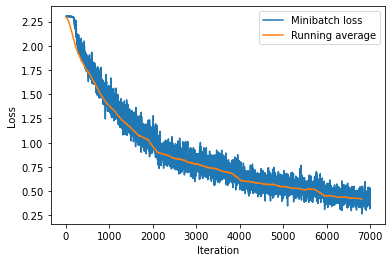

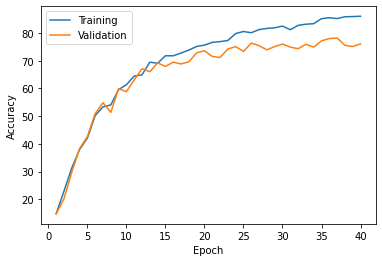

In [8]:
fig_loss, fig_acc = plot_training_params(log_dict)